In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import Image

## Introduction

The purpose of this tutorial is two-fold: 
- Demonstrate the quantum Krylov diagonalization algorithm for finding the ground-state energy of an important condensed matter physics Hamiltonian, the Heisenberg XXZ model, on a heavy-hex lattice, with exact diagonalization / state-vector simulation methods.
    
- Demonstrate classical Tensor-Network simulation methods for generic quantum circuits, and how they can be used to simulate and benchmark small to medium scale quantum circuits that are beyond the reach of exact diagonalization methods. In this tutorial, we use Matrix Product States to simulate the modified Hadamard test circuit from https://arxiv.org/pdf/2407.14431 for the quantum Krylov diagonalization algorithm for the XXZ model. MPS methods are not expected to scale well for 2D systems. However, they can faithfully simulate moderately entangled states for system sizes that are well beyond exact state-vector simulations. As such, they are a valuable tool to benchmark experiments before scaling up to utility-scale simulations.

<b> Krylov Quantum Diagonalization (KQD) </b>

Quantum subspace algorithms are a class of near-term friendly methods for finding extremal eigenvalues of Hermitian operators. We will focus on the method applied to finding the ground-state energy of physically motivated Hamiltonians. Specifically, for this tutorial we will consider the Heisenberg XXZ model on a heavy-hexagonal lattice that conforms with current IBM architectures.

The idea behind quantum subspace algorithms is to project the global eigenvalue problem onto a particular smaller subspace that captures the low-lying spectrum of the Hamiltonian. A quantum computer is used to calculate matrix elements of the projected operator in this subspace. KQD chooses this subspace to be a Krylov subspace, generated by unitary evolutino of the Hamiltonian. Specifically, consider a Hamiltonian $H$ with the corresponding propagator $U(t) = e^{-i H t}$ (assuming $t_0 = 0$), and an initial state $\ket{\psi_0}$. For a fixed time-evolution state $dt$, the Krylov subspace is defined as $\{\ket{\psi_0}, U(dt)\ket{\psi_0}, U^2(dt)\ket{\psi_0} \cdots U(dt)^{k-1}\ket{\psi_0} \}$ for a chosen subspace dimension $k$. The rough intuition for why this works comes from imaginary-time evolution -- a Krylov subspace spanned by basis vectors generated by powers of the Hamiltonian can be thought of as a taylor-expansion approximation to imaginary time evolved basis-vectors. Powers of unitary evolution by the Hamiltonian then acts as a proxy for the Hamiltonian powers. 

We can then project the Hamiltonian into the Krylov subspace as $H^{krylov}_{ij} = \bra{\psi_i} H \ket{\psi_j}$. Note that the Krylov subspace vectors $\{\ket{\psi}_i \}$ are not orthogonal; consequently the metric of the subspace will change with respect to the total Hilbert space, which is accounted for by the metric matrix $S^{krylov}_{ij} = \bra{\psi}_j\ket{\psi}_i$. We then solve the resulting generalized eigenvalue problem $$ H^{krylov} v = \lambda_v S^{krylov} v$$

For appropriately chosen $dt$ and sufficiently large Krylov dimension, we expect the lowest eigenvalue found from the the above generalized eigenvalue problem converges to the true ground-state energy.


<b> Modified Hadamard Test </b>

The quantum circuit for the Krylov algorithm using the generalized Hadamard to test to estimate the matrix elements of $H^{krylov}$ and $S^{krylov}$ in it's standard form is:

<img src="standard.png" style="height:200px">

However, this circuit required controlled time evolution to generate the $\ket{\psi_i}$ states which will result in prohibitive circuit depths for near-term hardware. Instead, we may use the following circuit

<img src="modified.png" style="height:200px">

We refer the reader to https://arxiv.org/pdf/2407.14431 for details of this replacement. We note that when $U$ is approximated by Trotter evolution, in addition to trotter error, there is also an approximation error from assuming that $U(i-j)$ and $U(j)$ commute, which is only true for ideal time-evolution. We expect that for sufficiently small $dt$ that this commutation error is negligible. However, note that the Krylov algorithm suffers from ill-conditioning effects when $dt$ is made too small. 

A benefit of this method is that it requires only a linear (in Krylov dimension) number of time evolutions, as the resulting H and S matrices expected from the modified Hadamard test are of Toeplitz form. Therefore, only the first row matrix elements of $H$ and $S$ need to be evaluated.

In [2]:
from lattice_afi import lattice_2d
from krylov_trotter_circuits import HeavyHexHeisenbergKrylovTNSim, solve_regularized_gen_eig
import numpy as np
from scipy.sparse import kron as spkron
from scipy.sparse.linalg import expm as sp_expm
from scipy.linalg import toeplitz   

## Matrix Product State (MPS) simulations of Krylov Quantum Diagonalization


<img src="mps.png" style="height:200px">

Matrix product states (MPS) are a class of quantum states with an efficient classical representation. The kIt is well known that the ground-states of gapped local Hamiltonians in 1-dimension have exact MPS representations. More generally, we may use MPS states and methods to simulate arbitrary quantum circuits, by initializing an MPS and applying single and two-qubit gates as on-site operators or Matrix Product Operators (MPO). Although MPS methods are ideally suited for 1-dimension, they can be used on two-dimensional systems by a winding a 1-D MPS through a 2-D spatial geometry (a lattice in this case). The key classical resource in for MPS methods is the so-called maximum bond-dimension of the MPS. The bond-dimension scales exponentially with the amount of entanglement in the system. MPS methods eventually fail for highly entangled 2D systems, as the bond-dimension grows with the system size due to highly non-local connections incurred by winding a 1D MPS through a 2D lattice, as well as the intrinsic entanglement growth of the underlying system. Nonetheless, MPS methods have been used successfuly to simulate quantum circuits upto modest depths that are beyond the reach of exact diagonalization and sparse linear algebra methods. We will not discuss the theory behind matrix product states in this demonstration, but refer the reader to https://arxiv.org/abs/0907.2796 for details. In the following section, we will simulate the Krylov diagonalization algorithm using MPS methods to simulate the modified Hadamard circuit described above. We will first demonstrate agreement with exact sparse matrix multiplication methods for a small system, and then run a larger example that cannot be simulated by exact methods.

## Heavy-Hex XXZ Model Krylov Simulation

We will consider the Heisenberg XXZ model on a heavy-hexagonal lattice (see figure below). The Hamiltonian is $$H = J*\sum_{i,j} (X_iX_j + Y_iY_j + \frac{g}{J} *Z_i*Z_J) $$

where the sum is over nearest-neighbors of the lattice. We first consider a small system consisting of a single plaquette of the lattice. In this case, a 1-D MPS can be wound around the plaquette. There is a single non-local connection between the first and last MPS site to account for the periodic coupling. The numbers on the outside of the lattice in the below figure show the MPS winding order.

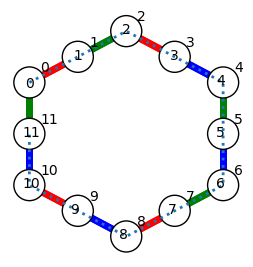

In [3]:
#Example lattice

mps_order = np.arange(12) #Do not need to set manually always. The default is optimized for a 2D heavy-hex lattice. 
                        #In this example, we consider a single plaquette so that the TN numerics can be benchmarked against exact calculations.
lat = lattice_2d(nx=1,ny=1, mps_order=mps_order) #Initialize lattice
lat.draw(show_gates=True, show_mps_order=True, enumerate_qubits=True)

Initialize Krylov algorithm parameters, and XXZ Hamiltonian parameters.

In [4]:
#Krylov algorithms parameters

dt = 0.1
trotter_order = 2
krylov_dim = 5

J = 1.0
g = -1.0

particle_inds = [0,2,4]

<b> Run the simulation to extract $H^{krylov}$ and $S^{krylov}$.

In [5]:
circ = HeavyHexHeisenbergKrylovTNSim(lat.nx, lat.ny, chi_max=64, J=J, g=g, mps_order=mps_order) #change lat.nx and lat.ny appropriately. chi_max is maximum bond dimension
circ.initialize_state(flip_inds=particle_inds) #lattice site indices to populate with a particle
S_tn = circ.krylov_S(krylov_dim=krylov_dim, dt=dt, trotter_order=trotter_order) #Build H and S matrices
H_tn = circ.krylov_H(krylov_dim=krylov_dim, dt=dt, trotter_order=trotter_order)

In [6]:
#Check Hermiticity
assert np.isclose(H_tn,H_tn.conj().T).all() and np.isclose(S_tn,S_tn.conj().T).all() #check Hermiticity

We will compare the resulting ground-state energy with an exact sparse matrix simulation of the same circuit below.

## Benchmark against Exact Matrix Multiplication

These are standard state-vector simulations -- skip to the end of this section to a see a comparison with the tensor network simulation.

In [7]:
#Initialize state

zero, one = np.array([1,0]), np.array([0,1])
X,Y,Z,I= np.array([[0,1],[1,0]]), np.array([[0,-1j],[1j,0]]), np.array([[1,0],[0,-1]]), np.eye(2)
H = np.sqrt(1/2)*np.array([[1,1],[1,-1]])

def tensor(op_list):
    op = op_list[0]
    for i in range(1, len(op_list)):
        op = spkron(op, op_list[i], format='csr')
    return op

edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1]]
l1_edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1] and v==1]
l2_edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1] and v==2]
l3_edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1] and v==3]
colored_edges = [l1_edges, l2_edges, l3_edges]

particle_inds_ED = np.array(particle_inds) + 1
psi = tensor([zero for _ in range(lat.n_qubits + 1)])
psi = psi.T

In [8]:
#State prep

H_gate = tensor([H]+[I for _ in range(lat.n_qubits)])
psi = H_gate@psi
state_prep_gates = tensor([np.outer(zero,zero)]+[I for i in range(1,lat.n_qubits+1)]) + \
      tensor([np.outer(one,one)]+[I if i != particle_inds_ED[0] else X for i in range(1,lat.n_qubits+1)])
for n in range(1,len(particle_inds_ED)):
    state_prep_gates = (tensor([np.outer(zero,zero)]+[I for i in range(1,lat.n_qubits+1)]) + \
      tensor([np.outer(one,one)]+[I if i != particle_inds_ED[n] else X for i in range(1,lat.n_qubits+1)]))@state_prep_gates
psi = state_prep_gates@psi

In [9]:
#Build Trotter gates

trotter_gates = []
for l in range(3):
    layer_gates = []
    for e in colored_edges[l]:
        XX = tensor([I]+[X if i in e else I for i in range(1, lat.n_qubits+1)])
        YY = tensor([I]+[Y if i in e else I for i in range(1, lat.n_qubits+1)])
        ZZ = tensor([I]+[Z if i in e else I for i in range(1, lat.n_qubits+1)])
        layer_gates.append(sp_expm(-1j*g*(dt/trotter_order)*ZZ)@sp_expm(-1j*J*(dt/trotter_order)*YY)@sp_expm(-1j*J*(dt/trotter_order)*XX))
    trotter_gates.append(layer_gates)

/opt/anaconda3/envs/research2/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/envs/research2/lib/python3.11/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


In [10]:
#Trotterized time-evolution

pre_measure_states = [psi.copy()]
for d in range(krylov_dim-1):
    for n in range(trotter_order):
        for l in range(3):
            for i in range(len(colored_edges[l])):
                psi = trotter_gates[l][i]@psi
    pre_measure_states.append(psi.copy())

In [11]:
#opposite control state prep circuit

inverse_state_prep_gates = tensor([np.outer(one,one)]+[I for i in range(1,lat.n_qubits+1)]) + \
      tensor([np.outer(zero,zero)]+[I if i != particle_inds_ED[0] else X for i in range(1,lat.n_qubits+1)])
for n in range(1,len(particle_inds_ED)):
    inverse_state_prep_gates = (tensor([np.outer(one,one)]+[I for i in range(1,lat.n_qubits+1)]) + \
      tensor([np.outer(zero,zero)]+[I if i != particle_inds_ED[n] else X for i in range(1,lat.n_qubits+1)]))@inverse_state_prep_gates
for d in range(krylov_dim):
      pre_measure_states[d] = inverse_state_prep_gates@pre_measure_states[d]

In [12]:
#Hamiltonian Pauli terms

X_terms, Y_terms, Z_terms = [],[],[]
for pair in edges:
    X_terms.append([I if i not in pair else X for i in range(1, lat.n_qubits+1)])
    Y_terms.append([I if i not in pair else Y for i in range(1, lat.n_qubits+1)])
    Z_terms.append([I if i not in pair else Z for i in range(1, lat.n_qubits+1)])

all_terms = X_terms + Y_terms + Z_terms
all_coeffs = [J for _ in range(len(X_terms)+len(Y_terms))] + [g for _ in range(len(Z_terms))]

In [13]:
#Hamiltonian Pauli terms

op_H_real = []
op_H_imag = []
for op_list in all_terms:
    op_H_imag.append(tensor([Y]+op_list))
    op_H_real.append(tensor([X]+op_list))
op_S_real = tensor([X]+[I for _ in range(lat.n_qubits)])
op_S_imag = tensor([Y]+[I for _ in range(lat.n_qubits)])

In [14]:
#Build Toeplitz Krylov Matrices

H_krylov_row1 = np.zeros(krylov_dim, dtype=np.complex128)
S_krylov_row1 = np.zeros(krylov_dim, dtype=np.complex128)
for d in range(krylov_dim):
    for i in range(len(all_terms)):
        H_krylov_row1[d] += (pre_measure_states[d].conj().T@op_H_real[i]@pre_measure_states[d] \
            + 1j* pre_measure_states[d].conj().T@op_H_imag[i]@pre_measure_states[d]).toarray()[0,0]*all_coeffs[i]
    S_krylov_row1[d] = (pre_measure_states[d].conj().T@op_S_real@pre_measure_states[d] \
        + 1j* pre_measure_states[d].conj().T@op_S_imag@pre_measure_states[d]).toarray()[0,0]
    
H_ed = toeplitz(H_krylov_row1.conj())
S_ed = toeplitz(S_krylov_row1.conj())


In [15]:
evals_ed = solve_regularized_gen_eig(H_ed, S_ed, threshold=1e-8)
evals_tn = solve_regularized_gen_eig(H_tn, S_tn, threshold=1e-8)

<b> Below we see that both methods agree essentially exactly. We explicitly check that</b>

In [16]:
print(evals_ed, evals_tn)

[-228.74732999] [-228.74732998]


In [17]:
np.isclose(S_ed, S_tn)

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [18]:
np.isclose(H_ed, H_tn)

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

## Larger System

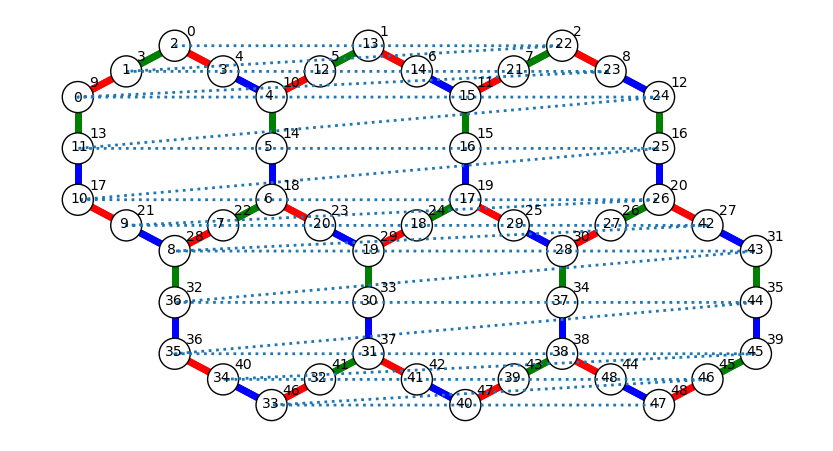

In [19]:
lat = lattice_2d(nx=3,ny=2) 
lat.draw(show_gates=True, show_mps_order=True, enumerate_qubits=True)

In [20]:
#Krylov algorithms parameters

dt = 0.2
trotter_order = 2
krylov_dim = 25

J = 1.0
g = 1.0

particle_inds = [0,2,16,34]

In [ ]:
circ = HeavyHexHeisenbergKrylovTNSim(lat.nx, lat.ny, chi_max=512, J=J, g=g) #change lat.nx and lat.ny appropriately. chi_max is maximum bond dimension
circ.initialize_state(flip_inds=particle_inds) #lattice site indices to populate with a particle
S_tn = circ.krylov_S(krylov_dim=krylov_dim, dt=dt, trotter_order=trotter_order) #Build H and S matrices
H_tn = circ.krylov_H(krylov_dim=krylov_dim, dt=dt, trotter_order=trotter_order)

In [ ]:
solve_regularized_gen_eig(H_ed, S_ed, threshold=1e-8)